In [14]:
from rapidocr import RapidOCR
from PIL import Image
import io
import json
from groq import Groq
import base64
import time
import pymupdf
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage,AIMessage
from langchain.schema import BaseMessage
from langchain.chat_models import init_chat_model
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_core.documents import Document

from typing import TypedDict,List
from pydantic import BaseModel, Field

import re
import tabula
from collections import Counter

from langgraph.types import Command, interrupt
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

from werkzeug.utils import secure_filename
from rank_bm25 import BM25Okapi
import math

In [2]:
api_key = "YOUR_GROQ_API_KEY"

In [3]:
class Parser:
    def __init__(self,api_key:str):
        self._api_key = api_key 
        self._engine = RapidOCR()
        with open('./sources.json','r') as f:
            self._sources = json.load(f)
            
    def _extract_captions_of_images(self,doc,page):
        imgs = page.get_images()
        client = Groq(api_key=self._api_key)
        captions = {}

        for i in range(len(imgs)):
            print("...VLM Called...",end="")

            xref = imgs[i][0]
            base_image = doc.extract_image(xref)

            #if image is unicolor that means it is either mask or artifact
            if base_image['colorspace']==1:
                continue

            image_bytes = base_image["image"]

            image_ext = base_image["ext"]

            image = Image.open(io.BytesIO(image_bytes))
            image = image.resize((360,180))
            output = io.BytesIO()
            # image
            image.save(output, format=image_ext)
            base64_image = base64.b64encode(output.getvalue()).decode('utf-8')

            start_time = time.time()
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": "Describe the image in no more than 100 words as much as possible/"},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}",
                                },
                            },
                        ],
                    }
                ],
                model="meta-llama/llama-4-scout-17b-16e-instruct",
            )

            captions[f"img_{xref}"] = chat_completion.choices[0].message.content

        return captions
        
    def _extract_using_ocr(self,page):
        print("...OCR called...",end="")
        img = page.get_pixmap()
        image_bytes = img.tobytes()
        image = Image.open(io.BytesIO(image_bytes))

        if image.width > image.height:
            image = image.rotate(90,expand=True)

        image = image.resize((400,800))
        result = self._engine(image)
        text = "\n".join(txt for txt in result.txts)
        
        return text

    def _extract_text_excluding_tables(self,page):
        tables = page.find_tables(strategy="lines_strict")
        table_bboxes = [table.bbox for table in tables]

        def is_inside_any_table_bbox(bbox):
            for table_bbox in table_bboxes:
                # print(table_bbox)
                if pymupdf.Rect(table_bbox).intersects(pymupdf.Rect(bbox)):
                    return True
            return False

        blocks = page.get_text("blocks")  
        filtered_text = [
            block[4] for block in blocks
            if not is_inside_any_table_bbox(block[:4])
        ]

        return "\n".join(filtered_text)
    
    def _extract_table_content(self,page):
        tables = page.find_tables()
        tables_list = [table.to_markdown() for table in tables]

        text = "\n".join(text for text in tables_list)

        return text
    def _get_table_from_pg(self,pdf_path,pg):
        tables = tabula.read_pdf(pdf_path,pages=str(pg+1),multiple_tables=True)
        return tables
    
    def _extract_formulas_from_text(self,text):
        formulas = []

        # 1. LaTeX inline math: $...$
        inline_latex = re.findall(r'\$(.+?)\$', text)
        formulas.extend([f.strip() for f in inline_latex])

        # 2. LaTeX display math: \[...\]
        display_latex = re.findall(r'\\\[(.+?)\\\]', text, flags=re.DOTALL)
        formulas.extend([f.strip() for f in display_latex])

        # 3. LaTeX equation environments
        env_latex = re.findall(r'\\begin{equation\*?}(.+?)\\end{equation\*?}', text, flags=re.DOTALL)
        formulas.extend([f.strip() for f in env_latex])

        # 4. LaTeX align environments
        align_envs = re.findall(r'\\begin{align\*?}(.+?)\\end{align\*?}', text, flags=re.DOTALL)
        formulas.extend([f.strip() for f in align_envs])

        # 5. ASCII/Unicode math heuristics (e.g., x^2 + y^2 = z^2 or x² + y² = z²)
        # Look for lines with multiple math symbols or variables
        math_lines = []
        for line in text.splitlines():
            if re.search(r'[a-zA-Z0-9][\^²³√±*/=<>+\-]+[a-zA-Z0-9]', line):
                if len(line.strip()) > 5:  # avoid noise
                    math_lines.append(line.strip())

        # Filter duplicates and obvious non-formulas
        for line in math_lines:
            if line not in formulas and not line.startswith('Figure') and '=' in line:
                formulas.append(line)

        return formulas
    
    
    def _common_font_size(self,pdf_path):
        doc = pymupdf.open(pdf_path)
        font_sizes = []

        for page in doc:
            blocks = page.get_text("dict")["blocks"]
            for b in blocks:
                if "lines" in b:
                    for line in b["lines"]:
                        for span in line["spans"]:
                            font_sizes.append(span["size"])
        counter = Counter(font_sizes)
        return counter.most_common()[0][0]

    def _format_headings(self,headings):
        prev_y = 0
        result = ""
        for heading in headings:
            if heading['bbox'][1]!=prev_y:
                result += "\n"
            result+=heading['text']+" "
            prev_y = heading['bbox'][1]
        return result

    def _get_headings(self,page,comm_font_size):
        headings = []
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            for line in block.get("lines", []):
                for span in line.get("spans", []):
                    font_size = round(span.get("size", 0))
                    font_flags = span.get("flags", 0)
                    text = span.get("text", "").strip()

                        # Skip empty strings
                    if not text:
                        continue

                        # Heuristic: large font size is probably a heading
                    if font_size > round(comm_font_size) or (font_size == round(comm_font_size) and (font_flags & pymupdf.TEXT_FONT_BOLD or "Bold" in span.get("font", ""))):
                        headings.append({
                            "text": text,
                            "size": font_size,
                            "font": span.get("font"),
                            "flags": font_flags,
                            "bbox": span.get("bbox"),
                        })

        return self._format_headings(headings)


    def parse_pdf(self,path):
        global log_messages
        log_messages.append("Parsing the pdf")
        doc = pymupdf.open(path)
        parsed = []
        comm_font_size = self._common_font_size(path)
        
        title=''
        source=''
        check = path.split('/')[-1]
        for d in self._sources:
            if d['path'].split('/')[-1]==check:
                title = d['title']
                source = d['url']
                break

        for i in range(doc.page_count):
            print(f"Page {i+1}",end="")

            full_pg = {}
            start_time = time.time()
            pg = doc.load_page(i)

            text = self._extract_text_excluding_tables(pg)
            
            if text == "" or text == []:
                text = self._extract_using_ocr(pg)
                img = {}
                table = ""
            else:
#                 img = self._extract_captions_of_images(doc,pg)
                img = {}
                table = self._extract_table_content(pg)
#                 table = self._get_table_from_pg(path,i)
                headings = self._get_headings(pg,comm_font_size)

            full_pg['text'] = text
            full_pg['tables'] = table
            full_pg['imgs'] = img
            full_pg['title'] = title
            full_pg['source'] = source
            full_pg['page'] = i+1
            full_pg['headings'] = headings
            full_pg['formulas'] = self._extract_formulas_from_text(text)
        
            parsed.append(full_pg)
            print(f"..Done.. {time.time()-start_time}")

        log_messages.append("PDF parsed")
        return parsed
    

In [4]:
parser = Parser(api_key=api_key)

In [5]:
pdf_dir = "./industrial-safety-pdfs/"
pdfs = [pdf for pdf in os.listdir(pdf_dir)]

In [10]:
pdf_path = './industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf'
result = parser.parse_pdf(pdf_path)

Page 1..Done.. 0.11742711067199707
Page 2..Done.. 0.64566969871521
Page 3..Done.. 0.3139228820800781
Page 4..Done.. 0.32817888259887695
Page 5..Done.. 0.6780681610107422
Page 6..Done.. 0.605309247970581
Page 7..Done.. 0.5846920013427734
Page 8..Done.. 0.38138699531555176
Page 9..Done.. 0.8398590087890625
Page 10..Done.. 0.9786009788513184
Page 11..Done.. 0.5797948837280273
Page 12..Done.. 1.30265212059021
Page 13..Done.. 0.7391400337219238
Page 14..Done.. 0.2436528205871582
Page 15..Done.. 1.9310309886932373
Page 16..Done.. 0.14016103744506836
Page 17..Done.. 0.32975292205810547
Page 18..Done.. 0.18933916091918945
Page 19..Done.. 0.9437332153320312
Page 20..Done.. 0.04095196723937988


In [11]:
result[4]

{'text': 'Safety in control systems according to EN ISO 13849-1 | 5\n\na\n\nb\n\nc\n\nd\n\ne\n\nPLr\n\n)\x14\n\n)\x15\n\n)\x14\n\n)\x15\n\n3\x14\n\n3\x15\n\n3\x14\n\n3\x15\n\n3\x14\n\n3\x15\n\n3\x14\n\n3\x15\n\nRisk estimation\n\nTo calculate the performance level required (PLr).\n\nS \n Severity of injury\nS1 \n slight (normally reversible injury)\nS2 \nserious (normally irreversible injury or death)\n\nF \n Frequency and/or exposure to hazard\nF1 \nseldom to less often and/or exposure time is short\nF2 \nfrequent to continuous and/or exposure time is long\n\nP \n Possibility of avoiding hazard or limiting harm\nP1 \npossible under specific conditions\nP2 \nscarcely possible\n\nStep 3 - Design and calculate the safety functions\nTo begin with you need to identify the safety functions on the \nmachine. (Examples of safety functions are emergency stop \nand monitoring of gate.)\n\nFor each safety function, a PLr should be established \n(which has often already been made in the risk asse

In [8]:
print(result[1]['text'])

2 | Safety in control systems according to EN ISO 13849-1

New standards for safety 
in control systems

Building a protection system that works in practice and provides sufficient safety requires expertise in several areas. 
The design of the safety functions in the protection system in order to ensure they provide sufficient reliability is a 
key ingredient. As help for this there is, for example, the EN ISO 13849-1 standard. With this document we aim to 
provide an introduction to the standard and its application in conjunction with our products.

Introducing the new standard

The generation change for standards on safety in control 
systems introduces new concepts and calculations for 
machine builders and machine users. The EN 954-1 standard 
(categories) is being phased out and replaced by EN ISO 
13849-1 (PL, Performance Level) and EN 62061 (SIL, Safety 
Integrity Level). Although the deadline for using EN 954-1 is 
set to 31/12/2011, it is beneficial to start applying the new 


In [6]:
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2", model_kwargs={"device": "cpu"})

/var/folders/gf/jln4qrcs5qb4c5ywqfg9qmsr0000gn/T/ipykernel_720/1344657105.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2", model_kwargs={"device": "cpu"})
2025-09-22 17:35:26.253737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple/miniconda3/envs/ML/lib/python3.10/site-packages/huggingface_hub/f

In [21]:
pdf_path

'./industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf'

In [17]:
import json
with open('./sources.json','r') as f:
    sources = json.load(f)

In [33]:
title=''
source=''
for d in sources:
    if d['path']==pdf_path:
        title = d['title']
        source = d['url']
        break

In [34]:
docs_list = [Document(page_content=page['text']+"\n\n"+page['tables']
                      +"\n\n"+"\n".join(page['imgs'][key] for key in page['imgs'].keys())+"\n\n"+
                      page['headings']+"\n\n"+'\n'.join(formula for formula in page['formulas']),
                          metadata={"page": page['page'],"imgs":False if not page['imgs'] else ",".join(img.split('_')[1] for img in page['imgs']), 
                                   'pdf_path':pdf_path,"title":title,"source":source,"headings":','.join(heading for heading in page['headings'].split('\n'))}) for page in result]



In [35]:
print(docs_list[1])

page_content='2 | Safety in control systems according to EN ISO 13849-1

New standards for safety 
in control systems

Building a protection system that works in practice and provides sufficient safety requires expertise in several areas. 
The design of the safety functions in the protection system in order to ensure they provide sufficient reliability is a 
key ingredient. As help for this there is, for example, the EN ISO 13849-1 standard. With this document we aim to 
provide an introduction to the standard and its application in conjunction with our products.

Introducing the new standard

The generation change for standards on safety in control 
systems introduces new concepts and calculations for 
machine builders and machine users. The EN 954-1 standard 
(categories) is being phased out and replaced by EN ISO 
13849-1 (PL, Performance Level) and EN 62061 (SIL, Safety 
Integrity Level). Although the deadline for using EN 954-1 is 
set to 31/12/2011, it is beneficial to start appl

In [37]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=200
)

doc_splits = text_splitter.split_documents(docs_list)

In [38]:
print(doc_splits[4])

page_content='What is the easiest way of complying 
with the standard?

1. Use pre-calculated components
As far as it is possible, use the components with pre-
calculated PL and PFHD-values. You then minimise 
the number of calculations to be performed. All ABB 
Jokab Safety products have pre-calculated PFHD-values.

2. Use the calculation tool
With the freeware application SISTEMA (see page 16) you 
avoid making calculations by hand. You also get help to 
structure your safety solutions and provide the necessary 
documentation.

3. Use Pluto or Vital 
Use the Pluto safety PLC or Vital safety controller. Not only 
is it easier to make calculations, but above all it is easier to 
ensure a higher level of safety.







New standards for safety 
in control systems 
Introducing the new standard 
PL or SIL? What should I use? 
• 
• 
What is PL (Performance Level)? 
• 
• 
• 
• 
• 
• 
What is the easiest way of complying 
with the standard? 
1. 
2. 
3.' metadata={'page': 2, 'imgs': False, 'p

In [7]:
vectorstore = Chroma(
    collection_name="industrial_docs2",
    embedding_function=embedding,
    persist_directory="./industrial_docs2",
    collection_metadata={"hnsw:space": "cosine"}
)

/var/folders/gf/jln4qrcs5qb4c5ywqfg9qmsr0000gn/T/ipykernel_720/1275157746.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [40]:
vectorstore.add_documents(documents=doc_splits)

['0100ef7d-7d68-43cc-a349-3cda2b103217',
 'f8eefc1a-33fc-43cb-bd7e-74b023c5c2b6',
 '7e2cd230-637a-4f1b-8c4b-5f281784dc95',
 '8eb1b3c4-e700-4ec2-b25e-7d45ded20bc1',
 '36043a35-748b-4bab-a0eb-c5714e1cfc1c',
 'd1d00750-2f6b-47fe-998c-56ee7655e176',
 '27116a2a-fedf-419f-be78-4974c8353ef3',
 '25aaa76e-c29e-4475-aa5a-5a49cb9158f6',
 'f968088b-21eb-4b3a-83f9-62c99ae900aa',
 'fd759ea0-24e5-4334-b75c-0f1640ee7a9c',
 '8a68735e-9f8c-424a-85e3-7eba2eabcafb',
 'cd4c00a0-02f3-429e-b037-24336db787ce',
 '53c4f821-0584-4a01-9e66-dfe110b7dc59',
 'f6caa5ed-c15c-482b-9a25-d9ba074eb7fc',
 '3c337100-4bd2-485a-9506-4b99cf6ab224',
 '682c60a0-951a-41d5-a90f-df28af3b4227',
 '27773669-7582-40fa-be35-d10739d13629',
 '11ba46ae-fe9f-4e66-b5f6-836d0ed6b239',
 '50f26f67-f5fa-4242-9a96-dc1e6959d9f7',
 '1a450dda-ae89-47dc-b09b-ba45820cc2ea',
 'a2f8b784-31e0-48a7-b43d-7570c02f6d22',
 'c3c56db6-b071-4606-9a83-8e9257aa5dfa',
 'c96f08ec-8610-4324-9579-ceb9a92a7f54',
 'f6d60fc8-83fe-438c-9d68-eef0ba2590d0',
 'af7e740b-00d5-

In [8]:
retriever = vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={'k': 5}
            )


In [9]:
query = "What is the easiest way of complying with the standard?"
topk = retriever.invoke(query)

In [10]:
print(topk[1])

page_content='What is the easiest way of complying 
with the standard?

1. Use pre-calculated components
As far as it is possible, use the components with pre-
calculated PL and PFHD-values. You then minimise 
the number of calculations to be performed. All ABB 
Jokab Safety products have pre-calculated PFHD-values.

2. Use the calculation tool
With the freeware application SISTEMA (see page 16) you 
avoid making calculations by hand. You also get help to 
structure your safety solutions and provide the necessary 
documentation.

3. Use Pluto or Vital 
Use the Pluto safety PLC or Vital safety controller. Not only 
is it easier to make calculations, but above all it is easier to 
ensure a higher level of safety.







New standards for safety 
in control systems 
Introducing the new standard 
PL or SIL? What should I use? 
• 
• 
What is PL (Performance Level)? 
• 
• 
• 
• 
• 
• 
What is the easiest way of complying 
with the standard? 
1. 
2. 
3.' metadata={'headings': ',New standards 

In [13]:
[doc.metadata['title'] for doc in topk]

['',
 'IFA â€” SISTEMA Cookbook 1',
 '',
 'OSHA 3170 â€” Safeguarding Equipment and Protecting Employees from Amputations',
 'IFA â€” Functional safety of machine controls (Application of EN ISO 13849), IFA Report 2/2017e']

In [62]:
results_w_score = vectorstore.similarity_search_with_relevance_scores(query,k=5)

In [63]:
corpus_for_bm = [result[0].page_content.split(" ") for result in results_w_score]

In [64]:
bm25 = BM25Okapi(corpus_for_bm)

In [89]:
doc_scores = bm25.get_scores(query.split(" "))
doc_scores

array([5.14321465, 1.8850707 , 1.65023817, 3.00014685, 1.89485945])

In [72]:
max_sc = max(doc_scores)
min_sc = min(doc_scores)

doc_score_nm = [(score-min_sc)/(max_sc-min_sc) for score in doc_scores]

In [73]:
doc_score_nm

[1.0, 0.0672299214048557, 0.0, 0.3864637201217327, 0.07003233102361199]

In [90]:
doc_score_nm = [(2 / math.pi) * math.atan(score) for score in doc_scores]

In [91]:
doc_score_nm

[0.8777467259170816,
 0.689497347227092,
 0.6531695855140075,
 0.7951765838201098,
 0.6908603785259866]

In [80]:


# results_w_score = vectorstore.similarity_search_with_score(query,k=5)

def rerank(topk):
    alpha = 0.6
    
    corpus_for_bm = [result[0].page_content.split(" ") for result in topk]
    bm25 = BM25Okapi(corpus_for_bm)
    doc_scores = bm25.get_scores(query.split(" "))
    doc_score_nm = [(2 / math.pi) * math.atan(score) for score in doc_scores]
    
    reranked = []
    for i,top in enumerate(topk):
        final_score = (alpha*topk[i][1])+((1-alpha)*doc_score_nm[i])
        
        reranked.append([topk[i][0],topk[i][1],doc_score_nm[i],final_score])
#         topk[i].append(final_score)
        
    reranked = sorted(reranked,key = lambda x:x[3],reverse=True)
    return reranked
    

In [81]:
r = rerank(results_w_score)

In [84]:
r[0]

[Document(metadata={'headings': ',New standards for safety ,in control systems ,Introducing the new standard ,PL or SIL? What should I use? ,• ,• ,What is PL (Performance Level)? ,• ,• ,• ,• ,• ,• ,What is the easiest way of complying ,with the standard? ,1. ,2. ,3. ', 'imgs': False, 'page': 2, 'pdf_path': './industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf'}, page_content='What is the easiest way of complying \nwith the standard?\n\n1. Use pre-calculated components\nAs far as it is possible, use the components with pre-\ncalculated PL and PFHD-values. You then minimise \nthe number of calculations to be performed. All ABB \nJokab\xa0Safety products have pre-calculated PFHD-values.\n\n2. Use the calculation tool\nWith the freeware application SISTEMA (see page 16) you \navoid making calculations by hand. You also get help to \nstructure your safety solutions and provide the necessary \ndocumentation.\n\n3. Use Pluto or Vital \nUse the Pluto safety PLC or Vital safety controll

In [90]:
r[0][0].metadata

{'headings': ',New standards for safety ,in control systems ,Introducing the new standard ,PL or SIL? What should I use? ,• ,• ,What is PL (Performance Level)? ,• ,• ,• ,• ,• ,• ,What is the easiest way of complying ,with the standard? ,1. ,2. ,3. ',
 'imgs': False,
 'page': 2,
 'pdf_path': './industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf'}

In [83]:
results_w_score[0]

(Document(metadata={'headings': ',New standards for safety ,in control systems ,Introducing the new standard ,PL or SIL? What should I use? ,• ,• ,What is PL (Performance Level)? ,• ,• ,• ,• ,• ,• ,What is the easiest way of complying ,with the standard? ,1. ,2. ,3. ', 'imgs': False, 'page': 2, 'pdf_path': './industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf'}, page_content='What is the easiest way of complying \nwith the standard?\n\n1. Use pre-calculated components\nAs far as it is possible, use the components with pre-\ncalculated PL and PFHD-values. You then minimise \nthe number of calculations to be performed. All ABB \nJokab\xa0Safety products have pre-calculated PFHD-values.\n\n2. Use the calculation tool\nWith the freeware application SISTEMA (see page 16) you \navoid making calculations by hand. You also get help to \nstructure your safety solutions and provide the necessary \ndocumentation.\n\n3. Use Pluto or Vital \nUse the Pluto safety PLC or Vital safety controll

In [137]:
class AgentState(TypedDict):
    query: str
    k:int
    pdf_path: list[str]
    result: str
    imgs: list[str]
    paper_url: str
    next_node: str
    prev_node: str
    chat_history: List[BaseMessage] 

In [155]:
def rerank(topk,query):
    alpha = 0.6
    
    corpus_for_bm = [result[0].page_content.split(" ") for result in topk]

    bm25 = BM25Okapi(corpus_for_bm)
    doc_scores = bm25.get_scores(query.split(" "))
    doc_score_nm = [(2 / math.pi) * math.atan(score) for score in doc_scores]
    
    reranked = []
    for i,top in enumerate(topk):
        final_score = (alpha*topk[i][1])+((1-alpha)*doc_score_nm[i])
        
        reranked.append([topk[i][0],topk[i][1],doc_score_nm[i],final_score])
        
    reranked = sorted(reranked,key = lambda x:x[3],reverse=True)
    return reranked

In [221]:
ret_chunks = []

In [238]:
class Agent:
    def __init__(self,vdb_name:str,vdb_path:str,api_key:str):
        self._api_key = api_key
        self._embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2", model_kwargs={"device": "cpu"})

        self._vectorstore = Chroma(
            collection_name=vdb_name,
            embedding_function=self._embedding,
            persist_directory=vdb_path,
            collection_metadata={"hnsw:space": "cosine"}
        )
        
        
        self._parser = Parser(api_key=api_key)
        
        self._text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=250
        )
        
        self._llm = init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct",temperature=0.2,api_key= api_key)
    

    def _parse_and_embed(self,state:AgentState):
        global log_messages
#         log_messages.append("In parse and embed")
        
        print("In parse_and_embed")
        
        for pdf in state['pdf_path']:
            print(f"Parsing {pdf}")
            result = self._parser.parse_pdf(pdf)
            pdf_path = "/".join(pdf.split('/')[:-1])+"/"+secure_filename(pdf.split('/')[-1])
        
            title,source = result[0]['title'],result[0]['source']
            
            docs_list = [Document(page_content=page['text']+"\n\n"+page['tables']
                      +"\n\n"+"\n".join(page['imgs'][key] for key in page['imgs'].keys())+"\n\n"+
                      page['headings']+"\n\n"+'\n'.join(formula for formula in page['formulas']),
                          metadata={"page": page['page'],"imgs":False if not page['imgs'] else ",".join(img.split('_')[1] for img in page['imgs']), 
                                   'pdf_path':pdf,"title":title,"source":source,"headings":','.join(heading for heading in page['headings'].split('\n'))}) for page in result]






            doc_splits = self._text_splitter.split_documents(docs_list)

            self._vectorstore.add_documents(documents=doc_splits)
        
            print(f"parsed and embedded the pdf {pdf}")

            return {'next_node':"rag_and_generate",'prev_node':'parse_and_embed'}

   
    def _rag_and_generate(self,state:AgentState):
        global log_messages, ret_chunks
        print("In rag_and_generate")
       
        docs = self._vectorstore.similarity_search_with_relevance_scores(state['query'],k=state['k']*2)
#         print(docs)
        reranked = rerank(docs,state['query'])

        content = "\n\n".join(docs[0].page_content+"\n\n\n"+"PDF Title:"+docs[0].metadata['title']+'\nPDF Source:'+docs[0].metadata['source']+"\nPage:"+str(docs[0].metadata['page']) for docs in reranked[:state['k']])
        
        for t in reranked[:state['k']]:
            z = t[0].to_json()
            z['similarity_score'] = t[1]
            ret_chunks.append(z)
        
        if reranked[0][3]>0.4:
            prompt = ChatPromptTemplate.from_messages([
                    ("system","""Use the following pieces of context to answer the question at the end.
                    If you don't know the answer, just say that you don't know, don't try to make up an answer.
                    Keep the answer as concise as possible. Try to explain as descriptive as possible.
                    Stay true to the contents. Make sure the answer is long and descriptive.
                    Always say "thanks for asking!" at the end of the answer
                    Cite the Title and Source Url at the bottom of response  from all the context."""),
                    MessagesPlaceholder('chat_history'),
                    (
                        "human", [
                            {"type": "text", "text": "Context: {context}\n\nInput: {input}"},
                        ]
                    )
            ])
            chain = prompt | self._llm

            result = chain.invoke({
                "input":state['query'],
                "chat_history":state['chat_history'],
                "context":content
            })
            state["chat_history"].append(HumanMessage(content=state['query']))
            state["chat_history"].append(AIMessage(content=result.content))

            return {'result': result.content,'imgs':[],'prev_node':"rag_and_generate"} 
            
        
        else:
            print('='*20)
            print("Score: ",reranked[0][3])
            print('='*20)
            
            return {'result': "Seems, like don't have much information to answer that question.",'imgs':[],'prev_node':"rag_and_generate"}  
            
        
            
        
         

    def _router(self,state:AgentState):
        print("In router")
        
        if state['pdf_path'] == None or state['pdf_path']==[]:
            return {'next_node':'rag_and_generate','prev_node':'router'}
        else:
            return {'next_node':'parse_and_embed','prev_node':'router'}
    

    def create_agent(self):
        graph = StateGraph(AgentState)
        checkpointer = MemorySaver()

        graph.add_node("Router",self._router)
        graph.add_node("parse_and_embed",self._parse_and_embed)
        graph.add_node("rag_and_generate",self._rag_and_generate)
      
        
        graph.set_entry_point("Router")


        graph.add_edge("parse_and_embed","rag_and_generate")
        graph.add_edge("rag_and_generate",END)

        graph.add_conditional_edges(
            "Router",
            lambda state: state['next_node'],
            {
                "parse_and_embed":"parse_and_embed",
                "rag_and_generate":"rag_and_generate",
            }
        )

        return graph.compile(checkpointer=checkpointer)
    

In [239]:
agent=Agent(vdb_name="industrial_docs2",vdb_path="./industrial_docs2",api_key=api_key)

agent = agent.create_agent()

/Users/apple/miniconda3/envs/ML/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


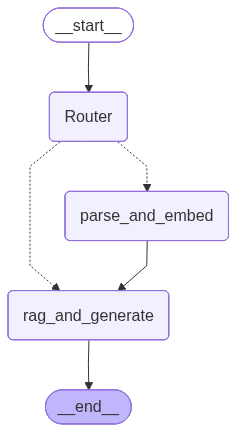

In [240]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [241]:
query = "What is the easiest way of complying with the standard?"

thread_config = {"configurable":{"thread_id":"some_id"}}

result = agent.invoke({
    "query":query,
    "pdf_path":None,
    "result":"",
    "imgs":[],
    "paper_url":None,
    "next_node":None,
    "chat_history":[]
},config=thread_config)

In router
In rag_and_generate


In [242]:
print(result['result'])

The easiest way of complying with the standard is to follow one of the three methods outlined:

1. **Use pre-calculated components**: Utilize components with pre-calculated PL (Performance Level) and PFHD (probability of dangerous failure per hour) values to minimize the number of calculations required. ABB Jokab Safety products, for instance, have pre-calculated PFHD-values.

2. **Use the calculation tool**: Leverage the freeware application SISTEMA to avoid manual calculations, structure safety solutions, and provide necessary documentation.

3. **Use Pluto or Vital**: Employ the Pluto safety PLC or Vital safety controller to simplify calculations and ensure a higher level of safety.

By adopting one of these approaches, you can streamline the process of complying with the standard, ensuring a more efficient and effective safety solution.

Thanks for asking!

Sources:
- ./industrial-safety-pdfs/EN_ISO_13849-1_2TLC172003B02002.pdf (Page: 2)
